# 인풋데이터 바로 받을 수 있게 코드 수정
1. 카테고리를 parameter로 받아 path 가져올 수 있는 함수 정의
2. 미리 모든 사진들에 대해 벡터화 해서 df에 담는 코드(csv로 저장까지)
3. 인풋 사진의 카테고리가 정해지면 그 폴더에서 데이터 프레임 가져오기
4. 인풋 사진에 대해서만 코사인 유사도 비교하기
    - 어차피 인풋 사진에 대한 코사인 유사도만 사용할 것이기 때문에, 굳이 모든 사진들에 대한 유사도를 구해놓을 필요는 없다.
    - 불러온 데이터 프레임에 가장 마지막 행에 인풋 사진의 벡터값을 append, 열 추가해서 인풋사진과의 유사도를 전부 입력
    - 이 과정에서의 시간을 time.time으로 비교해보기
5. 인풋 사진에 대해 코사인 유사도 높은 순으로 가져오기(임계값을 정해 그 값들만 가져올 수 있게 해보자)


# 모듈 임포트

In [1]:
import os
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # 반복문의 진행상황 확인하는 모듈
import glob

In [2]:
import time

# 모델 생성하기
- pre-trained 모델 가져오기

In [3]:
model_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"

IMAGE_SHAPE = (224, 224)

layer = hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE+(3,))
model = tf.keras.Sequential([layer])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              3413024   
                                                                 
Total params: 3,413,024
Trainable params: 0
Non-trainable params: 3,413,024
_________________________________________________________________


## 특징 벡터 추출함수

In [4]:
def extract(file):
    file = Image.open(file).convert('L').resize(IMAGE_SHAPE)
    file = np.stack((file,)*3, axis=-1)
    file = np.array(file)/255.0 # 정규화

    embedding = model.predict(file[np.newaxis, ...])
    vgg16_feature_np = np.array(embedding)
    flattended_feature = vgg16_feature_np.flatten()

    return flattended_feature

## 모든 이미지를 불러 벡터화해서 데이터프레임에 담아 csv로 넣어두기
- 이 코드는 실제 딥러닝 서비스 시에는 빼는 코드임
- 미리 돌려놔서 카테고리 내에 csv 형태로 저장해놓고, 나중에는 이 csv파일만 불러오거나, db에 벡터값을 저장해 놓는다고 가정하면 그 벡터값들만 불러오면됨
- db로딩이 더 오래 걸릴 것 같으므로 (pymysql 코드도 구동해야되니 오래걸릴 것 같음) csv 형태로 폴더에 담아 두는 것이 효율적일 듯 하다
- 아래 코드는 <font color='blue'>airflow 자동화</font>에 수정해서 사용
<br>
==========================================================

In [5]:
# 이미지 불러와서 데이터 프레임에 담기
def make_dataframe(category):
    path = f"../crops/{category}/"
    file_list = os.listdir(path)
    file_list_img = [file for file in file_list if file.endswith(".png") or file.endswith(".jpeg") or file.endswith(".jpg")]
    tmp_df = pd.DataFrame()
    for i, img in enumerate(tqdm(file_list_img)):
        output = extract(path+'/'+img)
        tmp_df = tmp_df.append({'filename':img, 'output':output}, ignore_index=True)

    np.save(path+f'{category}_filename(efficientNet).npy', tmp_df['filename'])
    np.save(path+f'{category}_output(efficientNet).npy', tmp_df['output']) # np.array배열 형태로 나중에 불러오기 위해 따로 저장
    

In [6]:
make_dataframe('cap')

100%|██████████| 3429/3429 [02:44<00:00, 20.88it/s]


In [7]:
# path = f"../crops/cap/"
# file_list = os.listdir(path)
# file_list_img = [file for file in file_list if file.endswith(".png") or file.endswith(".jpeg") or file.endswith(".jpg")]
# tmp_df = pd.DataFrame()
# for i, img in enumerate(tqdm(file_list_img)):
#     output = extract(path+'/'+img) 
#     tmp_df = tmp_df.append({'filename':img, 'output':output}, ignore_index=True)

# np.save('filename.npy', tmp_df.filename)
# np.save('output.npy', tmp_df.output)

# tmp_filename = np.load('filename.npy', allow_pickle=True)
# tmp_output = np.load('output.npy', allow_pickle=True)

# df_test = pd.DataFrame({'filename':tmp_filename, 'output':tmp_output})

================================================

## 카테고리를 받아 해당 카테고리의 데이터 프레임 불러오기

In [8]:
def get_dataframe(category):
    path = f"../crops/{category}/"
    tmp_filename = np.load(path+f'{category}_filename(efficientNet).npy', allow_pickle=True)
    tmp_output = np.load(path+f'{category}_output(efficientNet).npy', allow_pickle=True)
    df = pd.DataFrame({'filename':tmp_filename, 'output':tmp_output})
    return df

## 인풋 사진 받기 
- 사진 받아서 embbeding하기
- 다른 사진들과의 유사도를 전부 확인
- 데이터프레임에 다 넣는 함수 만들기

In [9]:
from scipy.spatial import distance
def get_cos_sim(file, category, metric='cosine'):
    before_time = time.time()
    file2vec = extract(file) # 이미지 벡터화
    df = get_dataframe(category) # 데이터프레임 가져오기
    df = df.append({'filename':file, 'output':file2vec}, ignore_index=True)
    
    cos_sim_array = np.zeros((len(df)))
    for i in range(0, len(df)):
        cos_sim_array[i] = distance.cdist([file2vec] , [df.iloc[i, 1]], metric)[0] # 벡터화된 이미지 기준
    df['cos_sim']=cos_sim_array
    after_time = time.time()
    print('소요시간 : {:.3f}초'.format(after_time-before_time))
    return df

In [12]:
def show_sim(filename, category):
    path = f"../crops/{category}/"
    cos_sim_df = get_cos_sim(filename, category)
    df_top_sim = cos_sim_df[cos_sim_df['cos_sim'] < 0.35].sort_values(by='cos_sim')

    # 그래프 그리는 부분은 서비스 시 생략 가능
    f, ax = plt.subplots(3, 5, figsize=(40, 20))

    for i in range(len(df_top_sim)):
        if i == 0: 
            tmp_img = Image.open(df_top_sim.iloc[i, 0]).convert('RGB')
            title = f'Original \n{df_top_sim.iloc[i, 0]}'
        else : 
            tmp_img = Image.open(path+'/'+df_top_sim.iloc[i, 0]).convert('RGB')
            title = f'similarity no.{i} \n{df_top_sim.iloc[i, 0]}'

        sim = f'cos : {df_top_sim.iloc[i, 2]:.3f}' 
        ax[i//5][i%5].imshow(tmp_img, aspect='auto')
        ax[i//5][i%5].set_title(title, pad=20, size=25) # 5열짜리 표를 만드는 것이므로 단순히 5로 나눈 나머지와 몫을 사용한 것임
        ax[i//5][i%5].annotate(sim, (0,10), fontsize=18, color='red')

    plt.show()

소요시간 : 0.275초


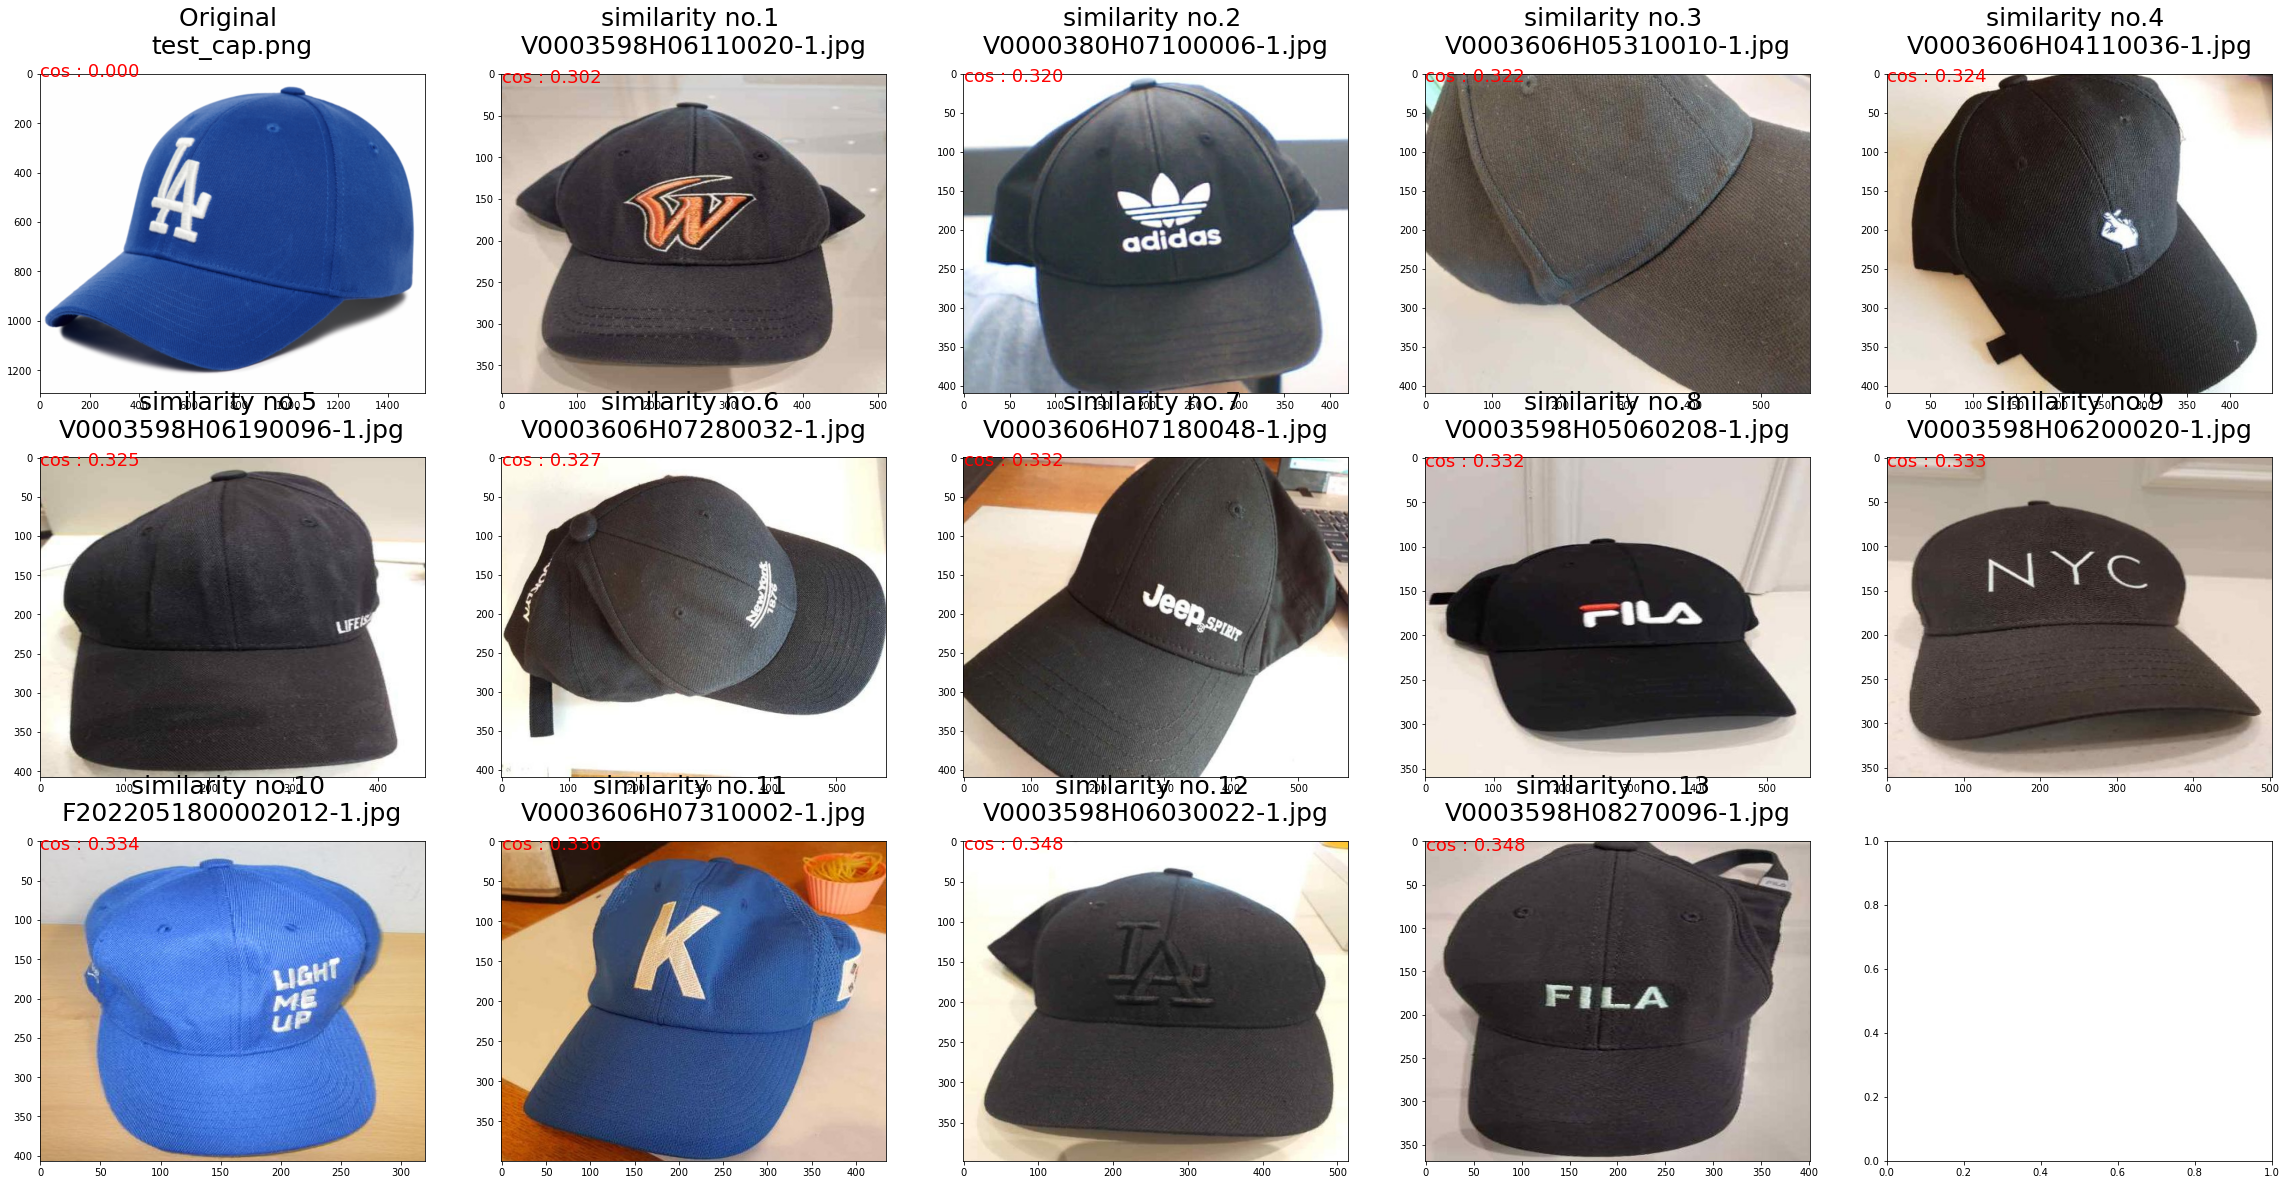

In [13]:
show_sim('test_cap.png', 'cap')